In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard, EarlyStopping
from tensorflow.keras.metrics import Recall, Precision, Accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:

#""" Global parameters """
height = 640
width = 1280
batch_size=2
data_path = "../content/drive/MyDrive/DS"

#""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_dir("files_s")

def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*JPG")))
    y = sorted(glob(os.path.join(path, "masks", "*png")))
    return x, y

def read_img(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_img(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    return x, y

def tf_ds(X, Y, batch=2, shuffle_buffer_size=1000, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(45)
    tf.random.set_seed(45)


 #"" Dataset """
    data_path = "../content/drive/MyDrive/DS"

    train_path = os.path.join(data_path, "train")
    valid_path = os.path.join(data_path, "test")

    train_x, train_y = load_data(train_path)
    valid_x, valid_y = load_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"valid: {len(valid_x)} - {len(valid_y)}")

    # Create datasets with and without data augmentation
    train_ds = tf_ds(train_x, train_y, batch=batch_size, augment=True)
    valid_ds = tf_ds(valid_x, valid_y, batch=batch_size)

Train: 500 - 500
valid: 50 - 50


Train: 500 - 500
Valid: 50 - 50
Batch shape: (2, 640, 1280, 3) (2, 640, 1280, 1)


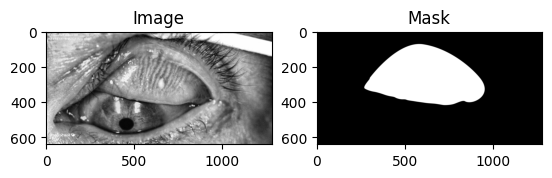

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt

""" Global parameters """
height = 640
width = 1280
batch_size = 2
data_path = "../content/drive/MyDrive/DS"

# Creating a directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_dir("files_s")

def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*JPG")))
    y = sorted(glob(os.path.join(path, "masks", "*png")))
    return x, y

def read_img(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_img(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    return x, y

# Example of data augmentation using tf.image operations
def augment_data(x, y):
    # Add your data augmentation operations here
    x = tf.image.flip_left_right(x)
    y = tf.image.flip_left_right(y)
    return x, y

def tf_ds(X, Y, batch=2, shuffle_buffer_size=1000, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.map(tf_parse)

    # Additional steps for data augmentation if needed
    if augment:
        ds = ds.map(augment_data)

    ds = ds.batch(batch)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(45)
    tf.random.set_seed(45)

    # Dataset
    train_path = os.path.join(data_path, "train")
    valid_path = os.path.join(data_path, "test")

    train_x, train_y = load_data(train_path)
    valid_x, valid_y = load_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    # Create datasets with and without data augmentation
    train_ds = tf_ds(train_x, train_y, batch=batch_size, augment=True)
    valid_ds = tf_ds(valid_x, valid_y, batch=batch_size)

    # Test the datasets
    for batch in train_ds.take(1):
        images, masks = batch
        print("Batch shape:", images.shape, masks.shape)

        # Display the first image and mask in the batch
        plt.subplot(1, 2, 1)
        plt.imshow(images[0])
        plt.title("Image")
        plt.subplot(1, 2, 2)
        plt.imshow(tf.squeeze(masks[0]), cmap='gray')
        plt.title("Mask")
        plt.show()


In [3]:
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Conv2DTranspose, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard, EarlyStopping
import tensorflow as tf

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = pool_size

    def call(self, inputs, **kwargs):
        ksize = [1, *self.pool_size, 1]
        strides = [1, *self.strides, 1]
        output, argmax = tf.nn.max_pool_with_argmax(inputs, ksize=ksize, strides=strides, padding='SAME')
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = [1, *self.pool_size, 1]
        output_shape = [dim // ratio[idx] if dim is not None else None for idx, dim in enumerate(input_shape)]
        return [tuple(output_shape), tuple(output_shape)]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]

def segnet_block(X, filters, block):
    b = 'block_' + str(block) + '_'
    f1, f2, f3, f4 = filters

    # Encoder
    conv1 = Conv2D(f1, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(X)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(f2, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1, mask1 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv1)

    # Decoder
    up1 = Conv2DTranspose(f3, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', strides=(2, 2))(pool1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(f4, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    up1 = BatchNormalization()(up1)

    # Output layer with a single channel and sigmoid activation
    output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer='he_normal')(up1)

    return output_layer

# Test the modified segnet_block function with a sample input
input_layer = Input(shape=(640, 1280, 3), name='input')
block1 = segnet_block(input_layer, [32, 32, 64, 64], '1')
print(block1.shape)

# Define the model
model_input = Input(shape=(640, 1280, 3), name='input')
model_output = segnet_block(model_input, [32, 32, 64, 64], '1')
model = tf.keras.Model(inputs=model_input, outputs=model_output)

# Use tf.keras.optimizers.Adam instead of tf.train.AdamOptimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Enable mixed precision for the optimizer
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer, dynamic=True)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy()]
)

# Callbacks
model_path = 'model_checkpoint.h5'
csv_path = 'training_logs.csv'
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, save_weights_only=True, save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-4, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(write_graph=False),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
]

# Use your adjusted train_ds and valid_ds
model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=callbacks
)


(None, 640, 1280, 1)
Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: -219.6860 - recall: 0.8507 - precision: 0.2709 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to -287.02786, saving model to model_checkpoint.h5
250/250 [==============================] - 664s 3s/step - loss: -219.6860 - recall: 0.8507 - precision: 0.2709 - accuracy: 0.0000e+00 - val_loss: -287.0279 - val_recall: 0.9204 - val_precision: 0.2435 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: -376.1429 - recall: 0.8309 - precision: 0.2865 - accuracy: 1.1792e-06
Epoch 2: val_loss improved from -287.02786 to -414.37811, saving model to model_checkpoint.h5
250/250 [==============================] - 71s 283ms/step - loss: -376.1429 - recall: 0.8309 - precision: 0.2865 - accuracy: 1.1792e-06 - val_loss: -414.3781 - val_recall: 0.8406 - val_precision: 0.2841 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/10
250/250 [======

In [5]:
# Global parameters
height = 640
width = 1280
data_path = "../content/drive/MyDrive/DS"

# Create result directory
result_path = os.path.join(data_path, "SEGRES", "result")
create_dir(result_path)

# Load the model with custom metric functions
model_path = "../content/drive/MyDrive/DS/segnet_files/model_checkpoint.h5"

model = tf.keras.models.load_model(model_path)

# Load the dataset
data_path = "../content/drive/MyDrive/DS"
valid_path = os.path.join(data_path, "test")
test_x, test_y = load_data(valid_path)
print(f"Test: {len(test_x)}")

# Evaluation
SCORE = []  # Initialize SCORE list

for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    # Image read
    img = cv2.imread(x, cv2.IMREAD_COLOR)
    x = img / 255.0
    x = np.expand_dims(x, axis=0)

    # Read mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

    # Prediction
    y_pr = model.predict(x)[0]
    y_pr = np.squeeze(y_pr, axis=-1)
    y_pr = y_pr > 0.5
    y_pr = y_pr.astype(np.int32)

    # Flatten the arrays
    mask_flat = mask.flatten()
    y_pr_flat = y_pr.flatten()

    # Calculate metrics
    acc_value = accuracy_score(mask_flat, y_pr_flat)
    f1_val = f1_score(mask_flat, y_pr_flat, average='weighted')  # Change average to 'weighted'
    jac_val = jaccard_score(mask_flat, y_pr_flat, labels=[0, 1], average='weighted')  # Change average to 'weighted'
    recall_val = recall_score(mask_flat, y_pr_flat, labels=[0, 1], average='weighted')  # Change average to 'weighted'
    precision_value = precision_score(mask_flat, y_pr_flat, labels=[0, 1], average='weighted')  # Change average to 'weighted'

    # Append metrics to SCORE list
    SCORE.append({
        'accuracy': acc_value,
        'f1_score': f1_val,
        'jaccard_score': jac_val,
        'recall': recall_val,
        'precision': precision_value
    })

# Calculate average metrics
average_metrics = {
    'average_accuracy': np.mean([score['accuracy'] for score in SCORE]),
    'average_f1_score': np.mean([score['f1_score'] for score in SCORE]),
    'average_jaccard_score': np.mean([score['jaccard_score'] for score in SCORE]),
    'average_recall': np.mean([score['recall'] for score in SCORE]),
    'average_precision': np.mean([score['precision'] for score in SCORE]),
}

print("Average Metrics:")
print(average_metrics)


ValueError: ignored

['batch_normalization_4', 'batch_normalization_5', 'batch_normalization_6', 'batch_normalization_7', 'conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_transpose_1', 'input', 'max_pooling_with_argmax2d_1', 'top_level_model_weights']


Train: 500 - 500
Valid: 50 - 50
Batch shape: (2, 640, 1280, 3) (2, 640, 1280, 1)


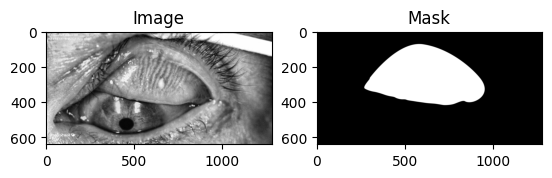

In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt

# Global parameters
height = 640
width = 1280
dataset_path = "../content/drive/MyDrive/DS"
files_directory = os.path.join(dataset_path, "files_train", "DS")
model_file = os.path.join(files_directory, "segnet.h5")
log_file = os.path.join(files_directory, "log-segnet.csv")

# Creating a directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_dir(files_directory)



def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*JPG")))
    y = sorted(glob(os.path.join(path, "masks", "*png")))
    return x, y

def read_img(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_img(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    return x, y

# Example of data augmentation using tf.image operations
def augment_data(x, y):
    # Add your data augmentation operations here
    x = tf.image.flip_left_right(x)
    y = tf.image.flip_left_right(y)
    return x, y

def tf_ds(X, Y, batch=2, shuffle_buffer_size=1000, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.map(tf_parse)

    # Additional steps for data augmentation if needed
    if augment:
        ds = ds.map(augment_data)

    ds = ds.batch(batch)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(45)
    tf.random.set_seed(45)

    # Dataset
    train_path = os.path.join(data_path, "train")
    valid_path = os.path.join(data_path, "test")

    train_x, train_y = load_data(train_path)
    valid_x, valid_y = load_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    # Create datasets with and without data augmentation
    train_ds = tf_ds(train_x, train_y, batch=batch_size, augment=True)
    valid_ds = tf_ds(valid_x, valid_y, batch=batch_size)

    # Test the datasets
    for batch in train_ds.take(1):
        images, masks = batch
        print("Batch shape:", images.shape, masks.shape)

        # Display the first image and mask in the batch
        plt.subplot(1, 2, 1)
        plt.imshow(images[0])
        plt.title("Image")
        plt.subplot(1, 2, 2)
        plt.imshow(tf.squeeze(masks[0]), cmap='gray')
        plt.title("Mask")
        plt.show()


In [15]:
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Conv2DTranspose, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard, EarlyStopping
import tensorflow as tf

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = pool_size

    def call(self, inputs, **kwargs):
        ksize = [1, *self.pool_size, 1]
        strides = [1, *self.strides, 1]
        output, argmax = tf.nn.max_pool_with_argmax(inputs, ksize=ksize, strides=strides, padding='SAME')
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = [1, *self.pool_size, 1]
        output_shape = [dim // ratio[idx] if dim is not None else None for idx, dim in enumerate(input_shape)]
        return [tuple(output_shape), tuple(output_shape)]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]

def segnet_block(X, filters, block):
    b = 'block_' + str(block) + '_'
    f1, f2, f3, f4 = filters

    # Encoder
    conv1 = Conv2D(f1, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(X)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(f2, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1, mask1 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv1)

    # Decoder
    up1 = Conv2DTranspose(f3, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', strides=(2, 2))(pool1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(f4, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    up1 = BatchNormalization()(up1)

    # Output layer with a single channel and sigmoid activation
    output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer='he_normal')(up1)

    return output_layer

# Test the modified segnet_block function with a sample input
input_layer = Input(shape=(640, 1280, 3), name='input')
block1 = segnet_block(input_layer, [32, 32, 64, 64], '1')
print(block1.shape)

# Define the model
model_input = Input(shape=(640, 1280, 3), name='input')
model_output = segnet_block(model_input, [32, 32, 64, 64], '1')
model = tf.keras.Model(inputs=model_input, outputs=model_output)

# Use tf.keras.optimizers.Adam instead of tf.train.AdamOptimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Enable mixed precision for the optimizer
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer, dynamic=True)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy()]
)

# ... (previous code)

# Callbacks
model_path = os.path.join(files_directory, 'model_checkpoint.h5')
csv_path = os.path.join(files_directory, 'training_logs.csv')
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, save_weights_only=True, save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-4, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(write_graph=False),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
]

# Use your adjusted train_ds and valid_ds
model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=callbacks
)



(None, 640, 1280, 1)
Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: -241.6168 - recall_3: 0.8031 - precision_3: 0.2817 - accuracy: 2.4414e-09
Epoch 1: val_loss improved from inf to -483.31384, saving model to ../content/drive/MyDrive/DS/files_train/DS/model_checkpoint.h5
250/250 [==============================] - 76s 287ms/step - loss: -241.6168 - recall_3: 0.8031 - precision_3: 0.2817 - accuracy: 2.4414e-09 - val_loss: -483.3138 - val_recall_3: 0.9524 - val_precision_3: 0.2370 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: -405.4841 - recall_3: 0.8259 - precision_3: 0.2927 - accuracy: 4.4824e-06
Epoch 2: val_loss improved from -483.31384 to -623.05450, saving model to ../content/drive/MyDrive/DS/files_train/DS/model_checkpoint.h5
250/250 [==============================] - 71s 284ms/step - loss: -405.4841 - recall_3: 0.8259 - precision_3: 0.2927 - accuracy: 4.4824e-06 - val_loss: -623.0545 - val_r

In [19]:
from tqdm import tqdm
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, recall_score, precision_score


from tensorflow.keras.layers import Input
# Calculate evaluation metrics using the trained model
SCORE = []  # Initialize SCORE list

for x, y in tqdm(zip(valid_x, valid_y), total=len(valid_x)):
    # Image read
    img = cv2.imread(x, cv2.IMREAD_COLOR)
    x = img / 255.0
    x = np.expand_dims(x, axis=0)

    # Read mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

    # Prediction using the trained model (model) instead of saved_model
    y_pr = model.predict(x)[0]
    y_pr = np.squeeze(y_pr, axis=-1)
    y_pr = y_pr > 0.5
    y_pr = y_pr.astype(np.int32)

    # Flatten the arrays
    mask_flat = mask.flatten()
    y_pr_flat = y_pr.flatten()

    # Calculate metrics
    acc_value = accuracy_score(mask_flat, y_pr_flat)
    f1_val = f1_score(mask_flat, y_pr_flat, average='weighted')
    jac_val = jaccard_score(mask_flat, y_pr_flat, labels=[0, 1], average='weighted')
    recall_val = recall_score(mask_flat, y_pr_flat, labels=[0, 1], average='weighted')
    precision_value = precision_score(mask_flat, y_pr_flat, labels=[0, 1], average='weighted')

    # Append metrics to SCORE list
    SCORE.append({
        'accuracy': acc_value,
        'f1_score': f1_val,
        'jaccard_score': jac_val,
        'recall': recall_val,
        'precision': precision_value
    })

# Calculate average metrics
average_metrics = {
    'accuracy': np.mean([score['accuracy'] for score in SCORE]),
    'f1_score': np.mean([score['f1_score'] for score in SCORE]),
    'jaccard_score': np.mean([score['jaccard_score'] for score in SCORE]),
    'recall': np.mean([score['recall'] for score in SCORE]),
    'precision': np.mean([score['precision'] for score in SCORE]),
}

print("Average Metrics:")
print(average_metrics)


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step


  2%|▏         | 1/50 [00:01<01:21,  1.67s/it]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 3/50 [00:03<00:53,  1.14s/it]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 4/50 [00:04<00:55,  1.20s/it]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 5/50 [00:05<00:47,  1.05s/it]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 6/50 [00:06<00:42,  1.04it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 7/50 [00:07<00:38,  1.11it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 8/50 [00:08<00:36,  1.15it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 9/50 [00:08<00:34,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 10/50 [00:09<00:32,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 11/50 [00:10<00:31,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 12/50 [00:11<00:30,  1.24it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 13/50 [00:12<00:36,  1.03it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 14/50 [00:14<00:39,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 15/50 [00:15<00:42,  1.20s/it]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 16/50 [00:16<00:42,  1.25s/it]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 17/50 [00:17<00:38,  1.16s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 18/50 [00:18<00:33,  1.06s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 19/50 [00:19<00:30,  1.02it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 20/50 [00:20<00:27,  1.09it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 21/50 [00:20<00:25,  1.14it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 22/50 [00:21<00:23,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 23/50 [00:22<00:22,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 24/50 [00:23<00:21,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 25/50 [00:24<00:20,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 26/50 [00:24<00:19,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 27/50 [00:25<00:18,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 28/50 [00:26<00:18,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 29/50 [00:27<00:18,  1.15it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 30/50 [00:29<00:20,  1.04s/it]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 31/50 [00:30<00:21,  1.12s/it]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 32/50 [00:31<00:21,  1.21s/it]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 33/50 [00:33<00:21,  1.24s/it]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 34/50 [00:33<00:17,  1.11s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 35/50 [00:34<00:15,  1.01s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 36/50 [00:35<00:13,  1.04it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 37/50 [00:36<00:12,  1.07it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 38/50 [00:37<00:10,  1.12it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 39/50 [00:38<00:09,  1.12it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 40/50 [00:38<00:08,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 41/50 [00:39<00:07,  1.19it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 42/50 [00:40<00:06,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 43/50 [00:41<00:05,  1.20it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 44/50 [00:42<00:04,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 45/50 [00:42<00:04,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 46/50 [00:44<00:03,  1.04it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 47/50 [00:46<00:03,  1.24s/it]

1/1 [==============================] - 0s 82ms/step


 96%|█████████▌| 48/50 [00:48<00:03,  1.63s/it]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 49/50 [00:50<00:01,  1.59s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 50/50 [00:51<00:00,  1.02s/it]

Average Metrics:
{'accuracy': 0.344326318359375, 'f1_score': 0.4687063199303909, 'jaccard_score': 0.42313307289540164, 'recall': 0.43509990891726913, 'precision': 0.941088635688301}
